**PROGETTO DEEP LEARNING**

Mariangela Tafuri, Paolo Simari, Vincenzo Picarelli.

**OBIETTIVO**

L'obiettivo di questo elaborato è riuscire a trovare un modello che, sfruttando le reti neurali, riesca a classificare al meglio delle immagini. Nello specifico, il dataset utilizzato è relativo ad immagini di cani e di gatti.

Link dataset : https://www.kaggle.com/datasets/tongpython/cat-and-dog

Si caricano inizialmente le librerie che verrano utilizzate durante l'analisi.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
import pathlib
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from torchvision import transforms

In [ ]:
print("GPU available" if tf.config.list_physical_devices("GPU") else "not available");

GPU available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Caricamento dati da drive.**

Le immagini sono divise in due cartelle, una relativa alle immagini di train e un'altra a quelle di test. 

In [ ]:
train_path = "/content/drive/MyDrive/progetto deep learning/cat vs dog/dataset/training_set"
test_path = "/content/drive/MyDrive/progetto deep learning/cat vs dog/dataset/test_set"
#save_model_path = "/content/drive/MyDrive/progetto deep learning/Model"
print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))

2
2


Le immagini di train e di test sono al loro volta divise in immagini di cani e immagini di gatti. Per tale motivo, si definiscono i percorsi relativi alle due categorie di immagini per il train e il test

In [ ]:
train_cats = train_path + '/cats'
train_dogs = train_path + '/dogs'
test_cats = test_path + '/cats'
test_dogs = test_path + '/dogs'

In [ ]:
print('number of cats training images - ',len(os.listdir(train_cats)))
print('number of dogs training images - ',len(os.listdir(train_dogs)))
print('number of cats training images - ',len(os.listdir(test_cats)))
print('number of dogs training images - ',len(os.listdir(test_dogs)))

number of cats training images -  4000
number of dogs training images -  4000
number of cats training images -  1000
number of dogs training images -  1000


Il train set è composto da 8000 immagini, di cui il 50% da immagini di cani e il restante da immagini di gatti. Per quanto riguarda il test, questo è composto da 2000 immagini, 1000 di cani e 1000 di gatti. Entrambi i dataset risultano essere perfettamente bilanciati e quello di train abbastanza numeroso.

A questo punto si definiscono alcune caratteristiche delle immagini e del modello:
- Batch size uguale a 128 per cercare di rendere le stime più stabili;
- le immagini avranno dimensione 150x150;
- si fissa il seme;
- il colore delle immagini sarà RGB.

In [ ]:
BATCH_SIZE = 128
IMG_WIDTH = 150
IMG_HEIGHT =  150
random_seed= 123
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Shape: {IMG_SHAPE}")

Batch Size: 128
Image Shape: (150, 150, 3)


Si fa una prima divisione di Train e Validation set. Nello specifico, si riscalano le immagini, in modo che siano comprese in valori tra 0 e 1 e la percentuale di validation set si fissa al 25% del train set. In più, si è deciso di dividere in train e validation set settando lo shuffle = True per rendere randomica la scelta.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  validation_split = 0.25)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'binary',
                                                   shuffle = True,
                                                   subset = 'training',
                                                   seed = random_seed)

validation_generator = train_datagen.flow_from_directory(train_path,
                                                        target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'binary',
                                                        subset = 'validation',
                                                        shuffle = True,
                                                        seed = random_seed)



Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Il dataset è bilanciato per entrambe le classi. 

Si crea il test set. Anche in questo caso si riscalano le immagini. 



In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/ 255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary',
                                                 shuffle = False,
                                                 seed=random_seed)

Found 2000 images belonging to 2 classes.


Si settano i label delle immagini.

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : cats
1 : dogs


Si visualizzano alcune immagini del train set.

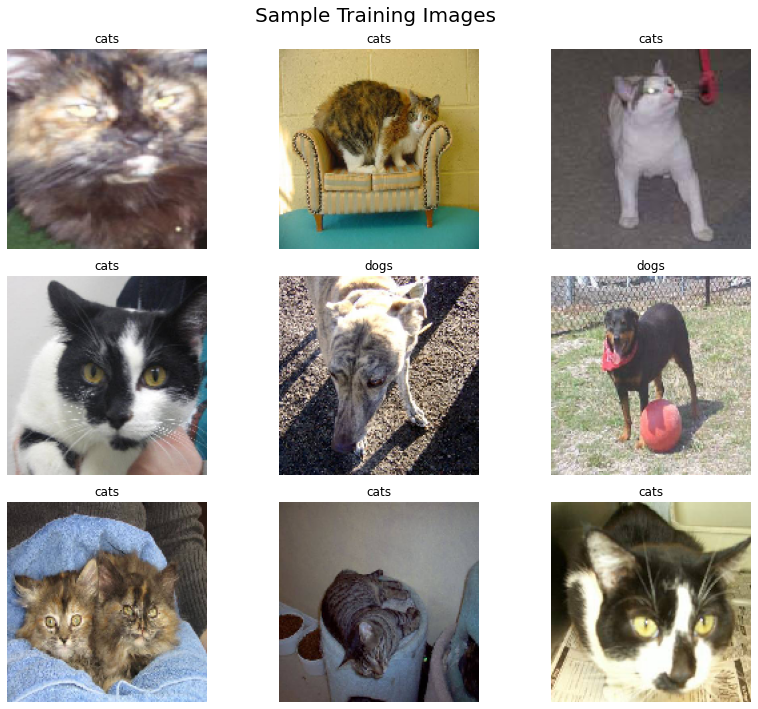

In [ ]:
ig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 10))
idx = 0
plt.suptitle("Sample Training Images ", fontsize = 20)
for i in range(3):
    for j in range(3):
        label = labels[train_generator[0][1][idx]]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

**ADDESTRAMENTO MODELLI**

Si defkiniscono diversi modelli e per ognuno si plottano i grafici riguardanti l'accuratezza e la funzione di perdita. Successivamente, si valutano i diversi modelli sul test set. 

**PRIMO MODELLO** 

Viene realizzata una prima rete "più semplice" composta tre hidden layers e senza inserire processi di regolarizzazione. La struttura della rete è così definita:
- Un primo blocco composto da Conv2D con 32 neuroni e successivo MaxPooling; 
- un secondo e un terzo blocco composti rispettivamente da 64 e 128 neuroni in input, con la struttura del precedente blocco.

Il layer Dense finale con 128 unità. Tutti i blocchi hanno funzione di attivazione 'relu'.
Siccome si affronta un problema di classificazione binaria, l'ultimo layer avrà una unità con fuzione di attivazione "sigmoid".  

L'ottimizzatore scelto è 'adam' e per lo stesso motivo sopra citato la loss è "binary crossentropy" e la metrica presa in considerazione è l'accuracy.



In [ ]:
model1 = Sequential()
model1.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = IMG_SHAPE))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Flatten())
model1.add(Dense(units = 128, activation = 'relu'))
model1.add(Dense(units = 1, activation = 'sigmoid'))
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Si fitta il modello con 30 epoche.

In [ ]:
history1 = model1.fit(train_generator, validation_data = validation_generator, 
                    epochs = 30)

Epoch 1/30
47/47 [==============================] - 2313s 49s/step - loss: 0.7415 - accuracy: 0.5092 - val_loss: 0.6812 - val_accuracy: 0.5740
Epoch 2/30
47/47 [==============================] - 30s 632ms/step - loss: 0.6615 - accuracy: 0.5952 - val_loss: 0.6449 - val_accuracy: 0.6040
Epoch 3/30
47/47 [==============================] - 30s 630ms/step - loss: 0.5919 - accuracy: 0.6853 - val_loss: 0.5699 - val_accuracy: 0.7065
Epoch 4/30
47/47 [==============================] - 31s 654ms/step - loss: 0.5267 - accuracy: 0.7365 - val_loss: 0.5468 - val_accuracy: 0.7225
Epoch 5/30
47/47 [==============================] - 30s 632ms/step - loss: 0.4817 - accuracy: 0.7668 - val_loss: 0.5146 - val_accuracy: 0.7490
Epoch 6/30
47/47 [==============================] - 30s 635ms/step - loss: 0.4296 - accuracy: 0.7970 - val_loss: 0.5076 - val_accuracy: 0.7445
Epoch 7/30
47/47 [==============================] - 30s 629ms/step - loss: 0.3949 - accuracy: 0.8227 - val_loss: 0.5229 - val_accuracy: 0.7400

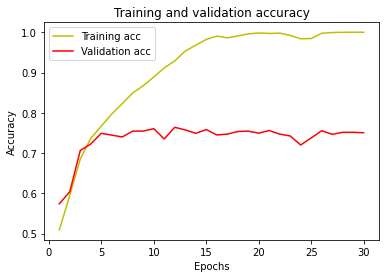

In [ ]:
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, 'y', label='Training acc')
plt.plot(epochs, val_acc1, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

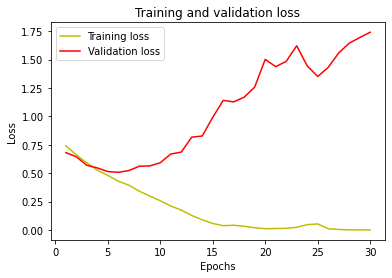

In [ ]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs = range(1, len(loss1) + 1)
plt.plot(epochs, loss1, 'y', label='Training loss')
plt.plot(epochs, val_loss1, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Si può notare dai due grafici che il modello va in overfitting. 

Si valutano, comunque, le performance sul test:

In [ ]:
test_loss1, test_accuracy1 = model1.evaluate(test_generator, batch_size=BATCH_SIZE)

print(f"Test Loss:     {test_loss1}")
print(f"Test Accuracy: {test_accuracy1}")

16/16 [==============================] - 1269s 85s/step - loss: 1.9555 - accuracy: 0.7445
Test Loss:     1.9554617404937744
Test Accuracy: 0.7444999814033508


Anche se l'accuratezza è del 74,45%, la loss è molta alta.
Dunque, si procede all'addestramento di un nuovo modello.
Nello specifico, si aggiunge il padding negli hidden layers "conv2d" e per ogni blocco il regolarizzatore drop out al 10%. In più i  dense layers finali sono ora due, un primo con 64 unità e un secondo con 128.

In [ ]:
model2 = Sequential()
model2.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',padding = 'same',  input_shape = train_generator.image_shape))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(rate = 0.1))
model2.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(rate = 0.1))
model2.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(rate = 0.1))
model2.add(Flatten())

model2.add(Dense(units = 64, activation = 'relu'))
model2.add(Dense(units = 128, activation = 'relu'))

model2.add(Dense(units = 1, activation = 'sigmoid'))
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history2 = model2.fit(train_generator, validation_data = validation_generator, 
                    epochs = 30)

Epoch 1/30
47/47 [==============================] - 33s 666ms/step - loss: 0.7044 - accuracy: 0.5117 - val_loss: 0.6911 - val_accuracy: 0.5470
Epoch 2/30
47/47 [==============================] - 30s 637ms/step - loss: 0.6748 - accuracy: 0.5808 - val_loss: 0.6404 - val_accuracy: 0.6615
Epoch 3/30
47/47 [==============================] - 31s 660ms/step - loss: 0.6237 - accuracy: 0.6532 - val_loss: 0.5985 - val_accuracy: 0.6855
Epoch 4/30
47/47 [==============================] - 30s 637ms/step - loss: 0.5507 - accuracy: 0.7197 - val_loss: 0.5884 - val_accuracy: 0.6890
Epoch 5/30
47/47 [==============================] - 30s 633ms/step - loss: 0.5123 - accuracy: 0.7427 - val_loss: 0.5266 - val_accuracy: 0.7385
Epoch 6/30
47/47 [==============================] - 30s 639ms/step - loss: 0.4540 - accuracy: 0.7892 - val_loss: 0.5145 - val_accuracy: 0.7470
Epoch 7/30
47/47 [==============================] - 30s 639ms/step - loss: 0.4279 - accuracy: 0.8042 - val_loss: 0.5942 - val_accuracy: 0.7255

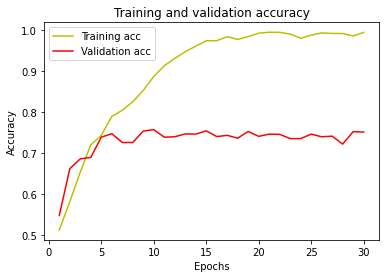

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, acc2, 'y', label='Training acc')
plt.plot(epochs, val_acc2, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

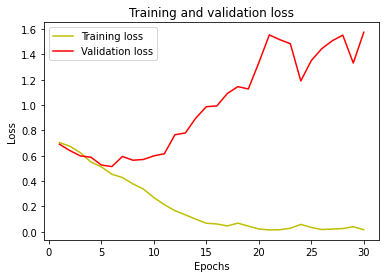

In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs = range(1, len(loss2) + 1)
plt.plot(epochs, loss2, 'y', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Anche in questo caso si nota che il modello soffre di overfitting.
Si valutano le performance del modello sul test.

In [ ]:
test_loss2, test_accuracy2 = model2.evaluate(test_generator, batch_size=BATCH_SIZE)

print(f"Test Loss:     {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

16/16 [==============================] - 7s 462ms/step - loss: 1.6883 - accuracy: 0.7505
Test Loss:     1.6882917881011963
Test Accuracy: 0.7505000233650208


Anche in questo caso l'accuratezza è di circa del 75%, ma loss è molto elevata.
Siccome, da come si osserva dai grafici, i modelli soffrono di overfitting, si divide nuovamente in train e validation set aggiungendo dei parametri per cercare di ovviare a questo problema. Nello specifico, si fa "data augmentation" aggiungendo lo zoom, lo shift in altezza e larghezza e l'horizontal flip.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  horizontal_flip = True,
                                  validation_split = 0.25)


In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'binary',
                                                   shuffle = True,
                                                   subset = 'training',
                                                   seed = random_seed)

validation_generator = train_datagen.flow_from_directory(train_path,
                                                        target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'binary',
                                                        subset = 'validation',
                                                        shuffle = True,
                                                        seed = random_seed)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/ 255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary',
                                                 shuffle = False,
                                                 seed=random_seed)

Found 2000 images belonging to 2 classes.


Si addestra, dunque, un nuovo modello, aggiungendo direttamente il regolarizzatore "drop out" e per i layers "Conv2D" si è inserito il padding. In più, si è aggiunto un ulteriore layer Dense con unità pari a 64.

In [ ]:
from keras import regularizers
from keras.layers import Dropout

In [ ]:
model4 = Sequential()
model4.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',padding = 'same',  input_shape = train_generator.image_shape))
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Dropout(rate = 0.1))
model4.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Dropout(rate = 0.1))
model4.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Dropout(rate = 0.1))
model4.add(Flatten())
model4.add(Dense(units = 64, activation = 'relu'))
model4.add(Dense(units = 128, activation = 'relu'))


model4.add(Dense(units = 1, activation = 'sigmoid'))
model4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history4 = model4.fit(train_generator, validation_data = validation_generator, 
                    epochs = 30)

Epoch 1/30
47/47 [==============================] - 74s 1s/step - loss: 0.7027 - accuracy: 0.5168 - val_loss: 0.6925 - val_accuracy: 0.5015
Epoch 2/30
47/47 [==============================] - 41s 872ms/step - loss: 0.6827 - accuracy: 0.5545 - val_loss: 0.6779 - val_accuracy: 0.5885
Epoch 3/30
47/47 [==============================] - 41s 881ms/step - loss: 0.6623 - accuracy: 0.5862 - val_loss: 0.6519 - val_accuracy: 0.6045
Epoch 4/30
47/47 [==============================] - 41s 878ms/step - loss: 0.6323 - accuracy: 0.6298 - val_loss: 0.6207 - val_accuracy: 0.6605
Epoch 5/30
47/47 [==============================] - 41s 876ms/step - loss: 0.5900 - accuracy: 0.6823 - val_loss: 0.5905 - val_accuracy: 0.6925
Epoch 6/30
47/47 [==============================] - 41s 871ms/step - loss: 0.5742 - accuracy: 0.6960 - val_loss: 0.5503 - val_accuracy: 0.7120
Epoch 7/30
47/47 [==============================] - 40s 863ms/step - loss: 0.5366 - accuracy: 0.7260 - val_loss: 0.5235 - val_accuracy: 0.7310
Ep

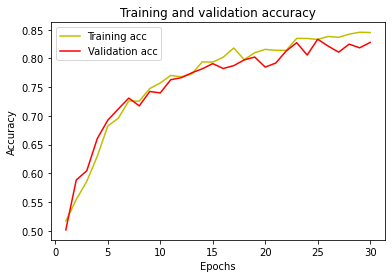

In [ ]:
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']

epochs = range(1, len(acc4) + 1)

plt.plot(epochs, acc4, 'y', label='Training acc')
plt.plot(epochs, val_acc4, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

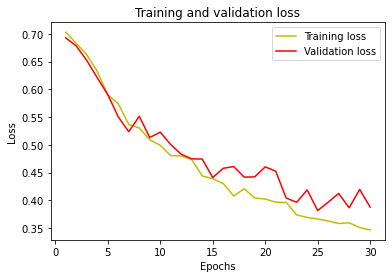

In [ ]:
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']
epochs = range(1, len(loss4) + 1)
plt.plot(epochs, loss4, 'y', label='Training loss')
plt.plot(epochs, val_loss4, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Come si può notare dai grafici, c'è un miglioramento nel modello e sembra che la data augmentation ha indotto una riduzione dell'overfitting. Relativamente al grafico raffigurante la loss, si può notare come fino alla decima epoca circa, la validitation loss sia più piccola rispetto alla training loss. Questo potrebbe accadere per via del drop out. Ad ogni modo, dopo la decima epoca il modello sembra stabilizzarzi. 

Si valutano le performance sul test set.

In [ ]:
test_loss4, test_accuracy4 = model4.evaluate(test_generator, batch_size=BATCH_SIZE)

print(f"Test Loss:     {test_loss4}")
print(f"Test Accuracy: {test_accuracy4}")

16/16 [==============================] - 10s 632ms/step - loss: 0.3860 - accuracy: 0.8400
Test Loss:     0.38595855236053467
Test Accuracy: 0.8399999737739563


L'accuracy è dell'84%. Questo è il modello migliore sia in termini di accuratezza che in termini di loss.

Si calcolano i valori predetti del test set e si plottano.

In [ ]:
predictions = model4.predict(test_generator)

16/16 [==============================] - 4s 229ms/step


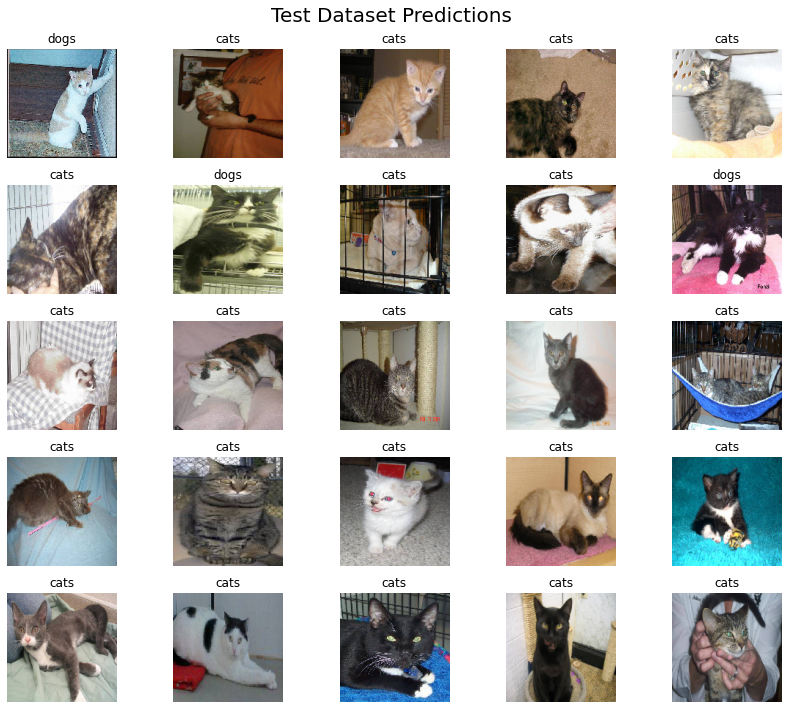

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12, 10))
idx = 0
plt.suptitle('Test Dataset Predictions ', fontsize=20)

for i in range(5):
    for j in range(5):
        predicted_label = labels[np.round(predictions.T[0][idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

Si calcola la matrice di confusione:

In [ ]:
y_pred = np.round(predictions)
y_pred = y_pred.T[0]          
y_true = test_generator.classes

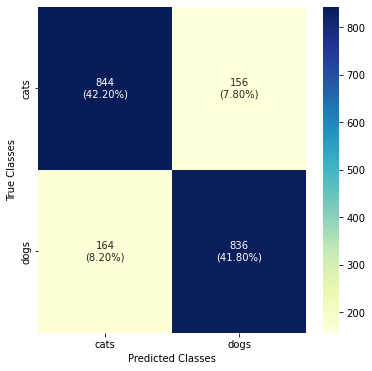

In [ ]:
from sklearn.metrics import confusion_matrix
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (6, 6))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

Possiamo notare che classifica in modo esatto i gatti al 42,20% mentre i cani al 41,80%. 

In [ ]:
sensitivita = (844/(844+164))*100
specificita = (836/(836+156))*100
print(sensitivita)
print(specificita)

83.73015873015873
84.2741935483871


A questo punto, si plottano le predizioni corrette ed errate:

In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

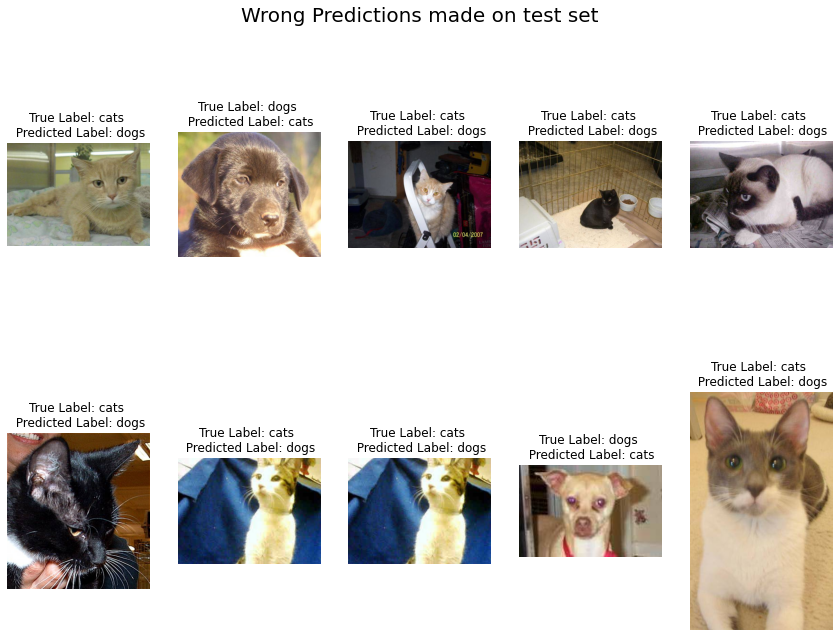

In [ ]:
import cv2

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

**FEATURE MAP**

Si implementano le feature maps per un'immagine test sia di un gatto che di un cane.
Nello specifico, si trasformano le immagini in array e si imposta il numero di layers da visualizzare pari a 6.

In [ ]:
successive_outputs = [layer.output for layer in model4.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model4.input, outputs = successive_outputs)

img=load_img("/content/drive/MyDrive/progetto deep learning/cat vs dog/dataset/test_set/cats/cat.4014.jpg", target_size=(150,150))
image = img_to_array(img)

image.shape


(150, 150, 3)

In [ ]:
img = image.reshape((1,150,150,3))
print(img.shape)

(1, 150, 150, 3)


In [ ]:
img = img/255

In [ ]:
feature_maps=visualization_model.predict(img)
print(len(feature_maps))

12


Activations 0:  (1, 75, 75, 32)
Activations 1:  (1, 75, 75, 32)
Activations 2:  (1, 75, 75, 64)
Activations 3:  (1, 37, 37, 64)
Activations 4:  (1, 37, 37, 64)
Activations 5:  (1, 37, 37, 128)
Activations 6:  (1, 18, 18, 128)
Activations 7:  (1, 18, 18, 128)
Activations 8:  (1, 41472)
Activations 9:  (1, 64)
Activations 10:  (1, 128)
Activations 11:  (1, 1)




(-0.5, 74.5, 74.5, -0.5)

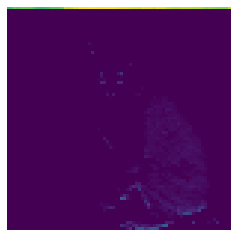

In [ ]:
layer_outputs = [layer.output for layer in model4.layers]  

activation_model = tf.keras.models.Model(inputs=model4.input, outputs=layer_outputs)

#activations = activation_model.predict(np.reshape(img, (1,150,150,3))) 
activations = feature_maps

for i,act in enumerate(activations):
  print(f'Activations {i}: ',act.shape) 

print('\n')

#activations of layer 0
layer_activation = activations[0]


plt.matshow(layer_activation[0, :, :, 4], cmap='viridis')
plt.axis('off')

In [ ]:
# nome dei layers inseriti nel modello.
layer_names = []
for layer in model4.layers:
  layer_names.append(layer.name)
  print(layer.name) 

conv2d_6
max_pooling2d_6
dropout_3
conv2d_7
max_pooling2d_7
dropout_4
conv2d_8
max_pooling2d_8
dropout_5
flatten_2
dense_5
dense_6
dense_7


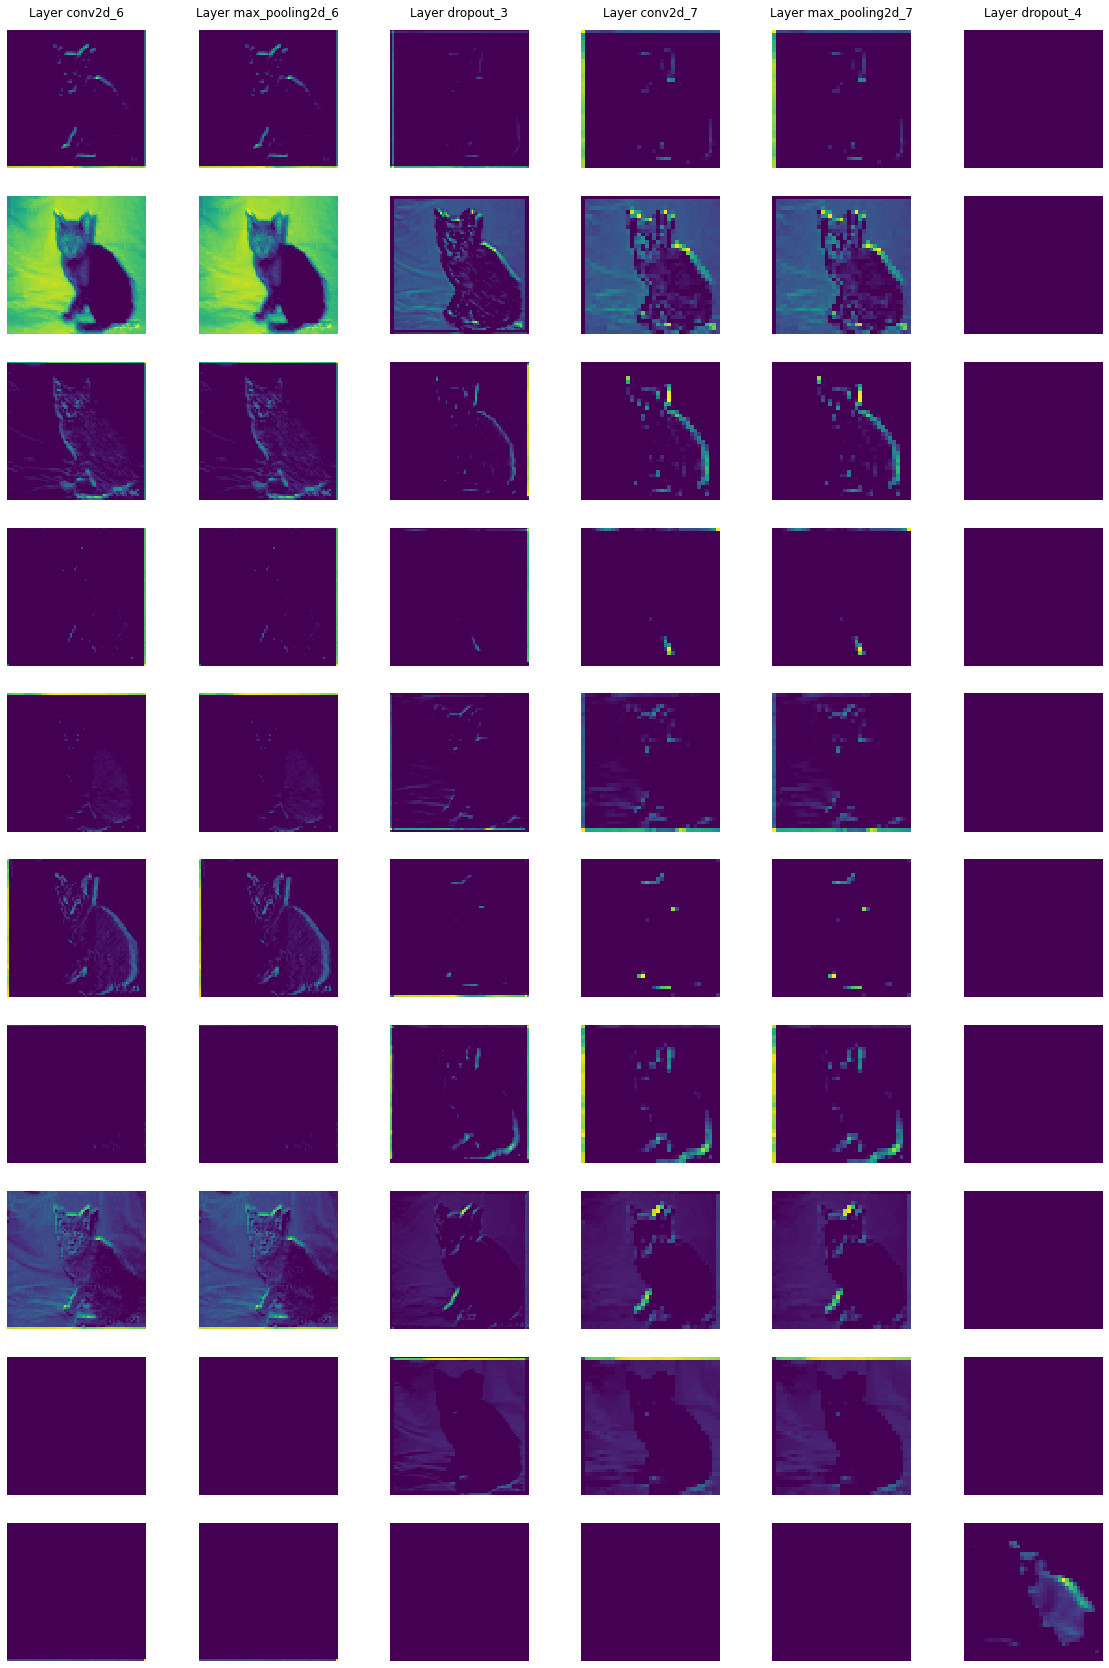

In [ ]:
channels_to_show = 10
plt.figure(figsize=(20, 30))

n_layers = 6

col=0

for layer_name, layer_activation in zip(layer_names[:n_layers], activations[:n_layers]):
    col +=1
    for i in range(channels_to_show):
      ax = plt.subplot(channels_to_show, n_layers, i*n_layers+col)
      ax.matshow(layer_activation[0,:,:,i], cmap='viridis')
      if i==0:
        plt.title(f'Layer {layer_name}')
      ax.axis("off")

In [ ]:
successive_outputs = [layer.output for layer in model4.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model4.input, outputs = successive_outputs)

img1=load_img("/content/drive/MyDrive/progetto deep learning/cat vs dog/dataset/test_set/dogs/dog.4006.jpg", target_size=(150,150))
image1 = img_to_array(img1)

image1.shape

(150, 150, 3)

In [ ]:
img1 = image1.reshape((1,150,150,3))
print(img1.shape)

(1, 150, 150, 3)


In [ ]:
img1 = img1/255

In [ ]:
feature_maps1=visualization_model.predict(img1)
print(len(feature_maps1))

12


Activations 0:  (1, 75, 75, 32)
Activations 1:  (1, 75, 75, 32)
Activations 2:  (1, 75, 75, 64)
Activations 3:  (1, 37, 37, 64)
Activations 4:  (1, 37, 37, 64)
Activations 5:  (1, 37, 37, 128)
Activations 6:  (1, 18, 18, 128)
Activations 7:  (1, 18, 18, 128)
Activations 8:  (1, 41472)
Activations 9:  (1, 64)
Activations 10:  (1, 128)
Activations 11:  (1, 1)




(-0.5, 74.5, 74.5, -0.5)

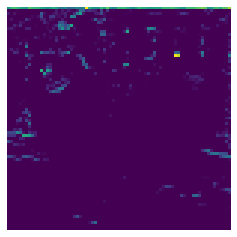

In [ ]:
layer_outputs = [layer.output for layer in model4.layers]  

activation_model = tf.keras.models.Model(inputs=model4.input, outputs=layer_outputs)

#activations = activation_model.predict(np.reshape(img, (1,150,150,3))) 
activations1 = feature_maps1

for i,act in enumerate(activations1):
  print(f'Activations {i}: ',act.shape) 

print('\n')

#activations of layer 0
layer_activation1 = activations1[0]


plt.matshow(layer_activation1[0, :, :, 4], cmap='viridis')
plt.axis('off')

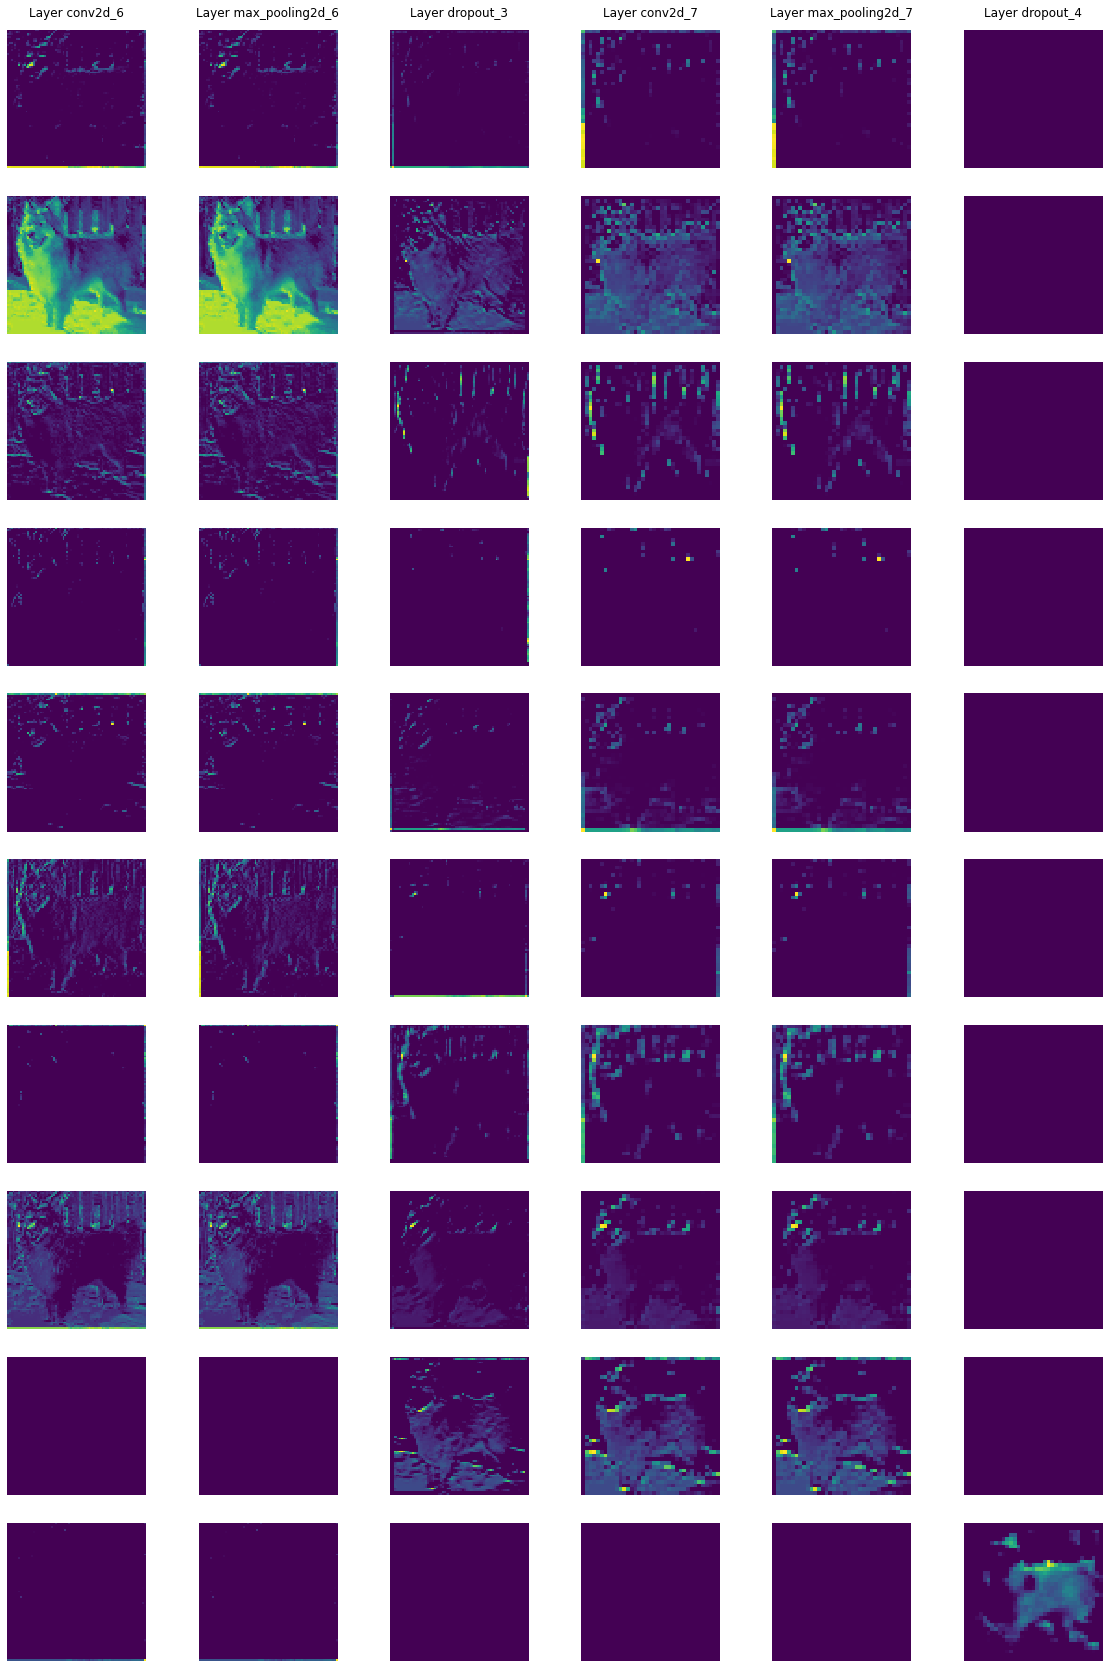

In [ ]:
# Feature map fo the first 6 layers
channels_to_show = 10
plt.figure(figsize=(20, 30))

n_layers = 6

col=0

for layer_name, layer_activation in zip(layer_names[:n_layers], activations1[:n_layers]):
    col +=1
    for i in range(channels_to_show):
      ax = plt.subplot(channels_to_show, n_layers, i*n_layers+col)
      ax.matshow(layer_activation[0,:,:,i], cmap='viridis')
      if i==0:
        plt.title(f'Layer {layer_name}')
      ax.axis("off")

**CONCLUSIONI**

Il modello finale si può considerare un buon modello, in quanto classifica con un'accuratezza dell'84%. Si potrebbe, però, migliorare il tutto, magari modificando la porzione di immagine da prendere in considerazione. Questo perché nel dataset sono presenti immagini che raffigurano cani e gatti con i loro "padroni" e immagini in cornici, il che potrebbe inficiare la corretta classificazione del modello stesso.